# Quickstart guide

In this notebook we will through all the steps from downloading the data and training a model to evaluating the results. Check out the `environment.yml` file for the required Python packages.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

DATA_DIR = 'data'

## Downloading the data

The data is hosted here. For this guide we will simply download the 500 hPa geopotential data (Z500).

In [2]:
# This might take a few minutes
# !sudo -E wget "https://dataserv.ub.tum.de/s/m1524895/download?path=%2F5.625deg&files=all_5.625deg.zip" -O /mnt/disks/weather_bench/all_5.625deg.zip

In [3]:
# !mkdir -p geopotential_500
# !unzip -d geopotential_500/ geopotential_500_5.625deg.zip

## Open the data

In [6]:
dataset = xr.open_mfdataset(f'{DATA_DIR}/new_region/*.nc', combine='by_coords')

In [7]:
dataset

<xarray.Dataset>
Dimensions:    (lat: 12, level: 13, lon: 14, time: 350640)
Coordinates:
  * lat        (lat) float64 -70.31 -64.69 -59.06 ... -19.69 -14.06 -8.438
  * lon        (lon) float64 247.5 253.1 258.8 264.4 ... 303.8 309.4 315.0 320.6
  * level      (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * time       (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    orography  (lat, lon) float32 dask.array<chunksize=(12, 14), meta=np.ndarray>
    lsm        (lat, lon) float32 dask.array<chunksize=(12, 14), meta=np.ndarray>
    slt        (lat, lon) float32 dask.array<chunksize=(12, 14), meta=np.ndarray>
    lat2d      (lat, lon) float64 dask.array<chunksize=(12, 14), meta=np.ndarray>
    lon2d      (lat, lon) float64 dask.array<chunksize=(12, 14), meta=np.ndarray>
    pv         (time, level, lat, lon) float32 dask.array<chunksize=(350640, 13, 12, 14), meta=np.ndarray>
    q          (time, level, lat, lon) float32 dask.array<chunksize=(350640, 13, 12, 14), meta=np.ndarray>
    r          (time, level, lat, lon) float32 dask.array<chunksize=(350640, 13, 12, 14), meta=np.ndarray>
    t          (time, level, lat, lon) float32 dask.array<chunksize=(350640, 13, 12, 14), meta=np.ndarray>
    t2m        (time, lat, lon) float32 dask.array<chunksize=(350640, 12, 14), meta=np.ndarray>
    tcc        (time, lat, lon) float32 dask.array<chunksize=(350640, 12, 14), meta=np.ndarray>
    u10        (time, lat, lon) float32 dask.array<chunksize=(350640, 12, 14), meta=np.ndarray>
    v10        (time, lat, lon) float32 dask.array<chunksize=(350640, 12, 14), meta=np.ndarray>
    vo         (time, level, lat, lon) float32 dask.array<chunksize=(350640, 13, 12, 14), meta=np.ndarray>
    z          (time, level, lat, lon) float32 dask.array<chunksize=(350640, 13, 12, 14), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-03-08 20:51:24 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

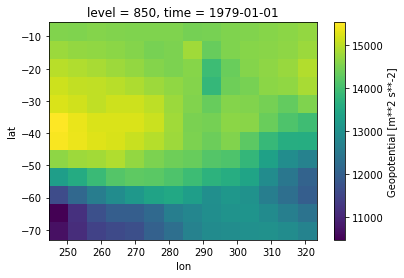

In [9]:
# Plot an example
dataset.z.isel(time=0, level=10).plot();

## Create a simple climatological forecast

Remember that we are using the years 2017 and 2018 for testing/evaluation, so we are not allowed to use these years to train any data-driven model.

For more information on the climatology and persistence forecasts used in the paper check out `notebooks/1-climatology-persistence.ipynb`.

In [10]:
# To speed things up we will just take the mean for 2016
climatology = dataset.sel(time=slice('2016', '2016')).mean('time').load()

(array([504., 211., 293., 168., 229., 233., 210., 112.,  56., 168.]),
 array([ -1579.4502,  18827.088 ,  39233.63  ,  59640.168 ,  80046.7   ,
        100453.24  , 120859.78  , 141266.33  , 161672.86  , 182079.4   ,
        202485.94  ], dtype=float32),
 <a list of 10 Patch objects>)

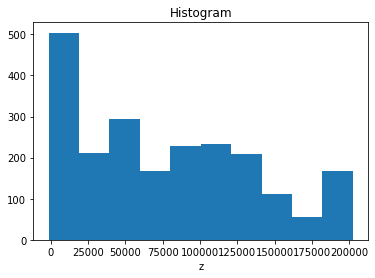

In [11]:
climatology.z.plot()

### Evaluate the climatology

Please check the paper for details on the evaluation metric. Here we will use the functions from `src/score.py`. To make sure we are always using the same targets for testing, we also implemented a function to load the test data.

In [12]:
from src.score import *

In [13]:
z500_test = load_test_data(f'{DATA_DIR}/new_region/', 'z')[::12]  # Take data only every 12 hours to speed up computation on Binder

In [14]:
rmse_climatology = compute_weighted_rmse(climatology.z, z500_test).load()

In [29]:
rmse_climatology

<xarray.DataArray ()>
array(1079.88382283)
Coordinates:
    level    int32 500

So we get a climatological RMSE of 1080 m^2/s^2 which is very similar to the RMSE we get for the climatology for all training years.

## Train a neural network

Now let's train a simple convolutional neural network. We are using several functions defined in `src/train_nn.py`. You can use and modify these or write your own function for data loading etc. 

For more information on the the networks check out `notebooks/3-cnn-example.ipynb`.

In [13]:
from src.train_nn import *

In [14]:
# This limits TF memory usage on the GPU
# limit_mem()

First, we need to create the data generators for training, validation and testing. The main reason why we are using data generators instead of just loading the data as Numpy arrays is that this would require loading the same data twice since the features and targets are the same fields, just offset in time. 

In [15]:
bs = 32
lead_time = 5*24
var_dict = {'z': None}

In [16]:
# Use 2015 for training and 2016 for validation
dg_train = DataGenerator(
    z500.sel(time=slice('2015', '2015')), var_dict, lead_time, batch_size=bs, load=True)
dg_valid = DataGenerator(
    z500.sel(time=slice('2016', '2016')), var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM
Loading data into RAM


In [17]:
# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator(z500.sel(time=slice('2017', '2018')).isel(time=slice(0, None, 12)), # Limiting the data for Binder
                        var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM


In [18]:
X, y = dg_train[0]

In [19]:
# Batches have dimensions [batch_size, lat, lon, channels]
X.shape, y.shape

((32, 32, 64, 1), (32, 32, 64, 1))

Now let's build a simple fully convolutional network. We are using periodic convolutions in the longitude direction. These are defined in `train_nn.py`.

In [20]:
cnn = keras.models.Sequential([
    PeriodicConv2D(filters=32, kernel_size=5, conv_kwargs={'activation':'relu'}, input_shape=(32, 64, 1,)),
    PeriodicConv2D(filters=1, kernel_size=5)
])

In [21]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
periodic_conv2d (PeriodicCon (None, 32, 64, 32)        832       
_________________________________________________________________
periodic_conv2d_1 (PeriodicC (None, 32, 64, 1)         801       
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________


In [22]:
cnn.compile(keras.optimizers.Adam(1e-4), 'mse')

In [23]:
# Train a little bit ;)
cnn.fit(dg_train, epochs=1, validation_data=dg_valid)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 270 steps, validate for 271 steps
270/270 [==============================] - 44s 164ms/step - loss: 1.7550 - val_loss: 0.9880


### Create a prediction and compute score

Now that we have a model (albeit a crappy one) we can create a prediction. For this we need to create a forecast for each forecast initialization time in the testing range (2017-2018) and unnormalize it. We then convert the forecasts to a Xarray dataset which allows us to easily compute the RMSE. All of this is taken care of in the `create_predictions()` function.

In [24]:
preds = create_predictions(cnn, dg_test)

Instructions for updating:
Please use Model.predict, which supports generators.


In [25]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 1340)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-02 ... 2018-12-31T12:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float32 51673.473 51733.367 ... 52438.395

In [30]:
compute_weighted_rmse(preds.z, z500_test).load()

<xarray.DataArray ()>
array(1239.17532377)

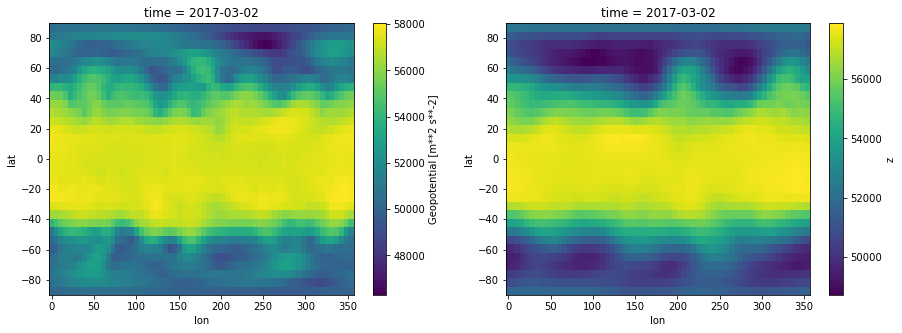

In [31]:
time = '2017-03-02T00'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
z500_test.sel(time=time).plot(ax=ax1)
preds.sel(time=time).z.plot(ax=ax2);

# The End

This is the end of the quickstart guide. Please refer to the Jupyter notebooks in the `notebooks` directory for more examples. If you have questions, feel free to ask them as a Github Issue.